In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/garbage-bins/Empty/IMG_1827.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_captured_from_above copy 2.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_captured_from_2_meters_above_sidewalk.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_2_meters_above copy 4.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_2_meters_above copy 9.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_3_meters_above copy 7.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_3_meters_above copy 12.png
/kaggle/input/garbage-bins/Empty/empty_open_garbage_bin_captured_from_2_meters_above_sidewalk.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_3_meters_above copy 10.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_2_meters_above copy 16.png
/kaggle/input/garbage-bins/Empty/empty_garbage_bin_angle_taken_from_3_meters_above copy.png
/kaggle/input/garbage-

In [2]:
!pip install opencv-python-headless
!pip install Augmentor

# installing the necessary libraries

In [3]:
import os
import Augmentor
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Make data augmentation to the dataset

In [4]:
import os
import Augmentor

dataset_dir = '/kaggle/input/garbage-bins'

image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

p = Augmentor.Pipeline(dataset_dir, output_directory='/kaggle/working/')

# The augmentation operations
p.rotate(probability=1, max_left_rotation=25, max_right_rotation=25)
p.flip_left_right(probability=0.5)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
p.random_color(probability=0.5, min_factor=0.5, max_factor=2.0)
p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.skew_tilt(probability=0.5)

#Number of augmented generated images
num_samples = 200

#Sgenerating augmented images
p.sample(num_samples)

Initialised with 101 image(s) found.
Output directory set to /kaggle/working/.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7916D8CA76A0>: 100%|██████████| 200/200 [02:05<00:00,  1.59 Samples/s]


# Process the data and buliding the model to evaluate it in the data

In [40]:
# Loading and preprocessing the images
def load_and_preprocess_images(directory, label):
    image_data = []
    labels = []

    for image_file in os.listdir(directory):
        image_path = os.path.join(directory, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (224, 224))
            image = image.astype('float32') / 255.0 # Normalize pixel values to [0, 1]
            image_data.append(image)
            labels.append(label)
            
    return np.array(image_data), np.array(labels)

#preprocessing images from the "empty" directory (label=0) and "full" directory (label=1)
empty_images, empty_labels = load_and_preprocess_images(os.path.join(dataset_dir, 'Empty'), label=0)
full_images, full_labels = load_and_preprocess_images(os.path.join(dataset_dir, 'Full'), label=1)


# Combining the data from both classes
X = np.concatenate([empty_images, full_images], axis=0)
y = np.concatenate([empty_labels, full_labels], axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Build the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [47]:
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=60, validation_split=0.2)

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/30
2/2 [==============================] - 2s 209ms/step - loss: 3.0490 - accuracy: 0.4844 - val_loss: 3.3457 - val_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - 0s 55ms/step - loss: 3.1836 - accuracy: 0.4844 - val_loss: 3.7743 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 0s 53ms/step - loss: 3.7097 - accuracy: 0.5156 - val_loss: 1.1273 - val_accuracy: 0.5000
Epoch 4/30
2/2 [==============================] - 0s 51ms/step - loss: 1.0407 - accuracy: 0.5469 - val_loss: 0.8976 - val_accuracy: 0.5000
Epoch 5/30
2/2 [==============================] - 0s 49ms/step - loss: 0.8902 - accuracy: 0.4844 - val_loss: 0.8298 - val_accuracy: 0.5000
Epoch 6/30
2/2 [==============================] - 0s 48ms/step - loss: 0.8112 - accuracy: 0.4844 - val_loss: 0.6855 - val_accuracy: 0.5000
Epoch 7/30
2/2 [==============================] - 0s 49ms/step - loss: 0.6508 - accuracy: 0.4844 - val_loss: 0.6477 - val_accuracy: 0.5000
Epoch 8/30
2/2 [==========

In [48]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 186624)            0         
                                                                 
 dense_24 (Dense)            (None, 128)             

# Results of the model

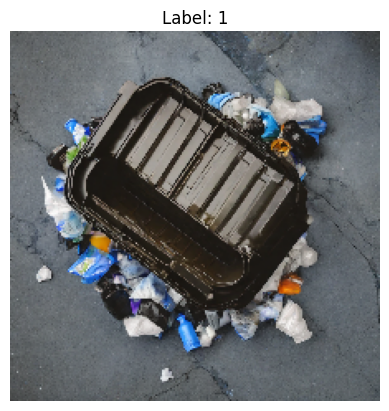

In [49]:
index = 20  #index from the test set # 1= full, 0=empty

#labeling at the specified index
sample_image = X_test[index] 
sample_label = y_test[index]

plt.imshow(sample_image)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()